# Logistic Regression using a Neural Network

We will use neural networks to build a logistic regression classifier for image recognition.

During the exercises, you will have to fill in the code between these comments:
```python
# CODE_START
<...your code here...>
# CODE_END
```

Please remember that we have to **vectorize** our code, therefore:

- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.
- Use `np.dot(X,Y)` to calculate dot products.

During the exercises you will:

- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

<a name='1'></a>
## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](https://numpy.org/doc/1.20/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [64]:
### v1.2

In [65]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *

%matplotlib inline
# Module autoreloading
%load_ext autoreload
%autoreload 2

[DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape `(num_px, num_px, 3)` where 3 is for the 3 channels (RGB). Thus, each image is square `(height = num_px)` and `(width = num_px)`.

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [66]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [0], it's a 'non-cat' picture.


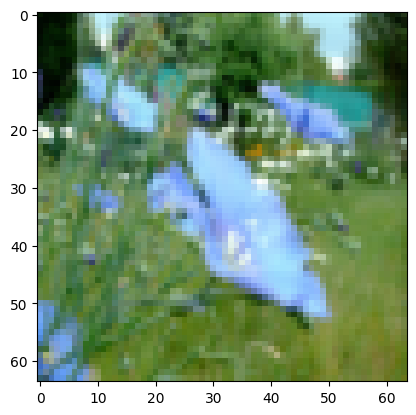

In [67]:
# Example of a picture
index = 20
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

**Important**: many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

<a name='ex-1'></a>
### Exercise 1
Find the values for:
- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)
- 
Remember that `train_set_x_orig` is a numpy-array of shape `(m_train, num_px, num_px, 3)`. For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [68]:
#(≈ 3 lines of code)
# m_train = 
# m_test = 
# num_px = 
# CODE_START

def unpack_sample_shape(sample: np.ndarray) -> tuple:
    
    if not isinstance(sample, np.ndarray):
        raise TypeError('Invalid sample type.')
    
    if not len(sample.shape) == 4:
        raise ValueError('Invalid sample shape.')
    
    return sample.shape[0], sample.shape[1]

# Time: O(1)
# Space: O(1)

# CODE_END
m_train, num_px = unpack_sample_shape(train_set_x_orig)
m_test, _ = unpack_sample_shape(test_set_x_orig)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))



Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

<a name='ex-2'></a>
### Exercise 2
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [69]:
# Reshape the training and test examples
#(≈ 2 lines of code)
# train_set_x_flatten = ...
# c = ...
# CODE_START

def flatten(sample: np.ndarray) -> np.ndarray:
    if not isinstance(sample, np.ndarray):
        raise TypeError()
    
    if len(sample.shape) != 4:
        raise ValueError()
    
    return sample.reshape(sample.shape[0], -1).T

train_set_x_flatten = flatten(train_set_x_orig)
test_set_x_flatten = flatten(test_set_x_orig)
# # CODE_END

# # Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [70]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

**Common steps for pre-processing a new dataset** are:

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

<a name='4'></a>
## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

<a name='4-1'></a>
### 4.1 - Helper functions

<a name='ex-3'></a>
### Exercise 3 - sigmoid
First, please implement `sigmoid()` function. As you've seen in the figure above, you need to compute 
$$
sigmoid(z) = \frac{1}{1 + e^{-z}}
$$
for $z = w^T x + b$ to make predictions. Use `np.exp()`.

In [71]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    if not isinstance(z, (int, float, np.ndarray)):
        raise TypeError()    
    
    return  1 /( 1 + np.e ** (-z))

In [72]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid_test(sigmoid)

sigmoid([0, 2]) = [0.5        0.88079708]
All tests passed!


In [73]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


In [74]:
# function representatino decorator
from typing import Callable

class FuncRepr:
    __slots__ = 'func', 'func_repr'
    
    def __init__(self, func: Callable, func_repr: str) -> None:
        self.func = func
        self.func_repr = func_repr
        
    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)
    
    def __repr__(self) -> str:
        return self.func_repr

<a name='4-2'></a>
### 4.2 - Initializing parameters

<a name='ex-4'></a>
### Exercise 4 - initialize_with_zeros
Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up `np.zeros()` in the Numpy library's documentation.

In [75]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim: int) -> tuple[np.ndarray, float] :   
    if not isinstance(dim, int):
        raise TypeError('DIMESION HAS TO BE OF TYPE INT, STOP PLAYING ON JOB')

    return np.expand_dims(np.zeros(dim), 1), 0.0

initialize_with_zeros = FuncRepr(initialize_with_zeros, 'initialize_with_zeros()')
initialize_with_zeros

initialize_with_zeros()

In [76]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

initialize_with_zeros_test_1(initialize_with_zeros)
initialize_with_zeros_test_2(initialize_with_zeros)


w = [[0.]
 [0.]]
b = 0.0
First test passed!
Second test passed!


<a name='4-3'></a>
### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

<a name='ex-5'></a>
### Exercise 5 - propagate
Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum\limits_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [77]:
import logging
from typing import Callable
logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s]: %(message)s')


# type alias for propagation
Propagation = Callable[[np.ndarray, float, np.ndarray, np.ndarray], dict]

class Propagate:

  @staticmethod
  def _type_check(sample: any, required_type: any) -> None:
    if not isinstance(sample, required_type):
      logging.error(f'ERROR in _type_check, Invalid sample: {sample}')
      raise TypeError(f'Input has to be of type: {required_type}, got: {type(sample)}')


  @staticmethod
  def _shape_check(x1: np.ndarray, x2: np.ndarray) -> None:
    if x1.T.shape[-1] != x2.shape[0]:
      logging.error(f'ERROR in _shape_check, shapes: ({x1.shape}, {x2.shape})')
      raise ValueError(f'Can not multiply matices with shapes: {x1.shape}, {x2.shape}')


  def _prediction(self,w: np.ndarray, b: float, X: np.ndarray) -> int:
    for sample, required_type in ((w, np.ndarray), (b, float), (X, np.ndarray)):
      self._type_check(sample, required_type)

    self._shape_check(w, X)

    return sigmoid(w.T @ X + b)


  def _grad(self, w, b, X, Y) -> int:
    A = self._prediction(w, b, X)
    self._shape_check(X.T, A.T)

    return (X @ (A - Y).T)/ X.shape[1], np.mean(A - Y)


  def _cost(self, w, b, X, Y) -> int:
    for sample, required_type in ((w, np.ndarray), (b, float), (X, np.ndarray), (Y, np.ndarray)):
      self._type_check(sample, required_type)

    A = self._prediction(w, b, X)
    return -np.mean(Y * np.log(A)+ (1 - Y) * np.log(1 - A))


  def __call__(self, w, b, X, Y) -> int:
    cost = self._cost(w, b, X, Y)
    grads = dict(zip(('dw', 'db'), self._grad(w, b, X, Y)))

    return grads, cost

  def __repr__(self) -> str:
    return f"Propagate()"
  
propagate = Propagate()
propagate

Propagate()

In [78]:
w =  np.array([[1.], [2]])
b = 1.5

# X is using 3 examples, with 2 features each
# Each example is stacked column-wise
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

propagate_test(propagate)

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405
All tests passed!


**Expected output**

```
dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405
```

<a name='4-4'></a>
### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

<a name='ex-6'></a>
### Exercise 6 - optimize
Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [79]:
# type alias for optimization
Optimization = Callable[[np.ndarray, float, np.ndarray, np.ndarray], dict]

def optimize(w: np.ndarray, 
             b: float, 
             X: np.ndarray, 
             Y: np.ndarray, 
             num_iterations: int = 100, 
             learning_rate: float = 0.009, 
             print_cost: bool = False, 
             save_cost: int = 10,
             propagate: Propagation = propagate):
  
  # log propagate fucntion
  logging.info(f'Propagation function: {propagate}')

  # store costs
  costs = []

  for epoch in range(num_iterations):
    grads, cost = propagate(w, b, X, Y)
    w -= learning_rate * grads.get('dw', 0)
    b -= learning_rate * grads.get('db', 0)

    if epoch % save_cost == 0:
      costs.append(('Epoch', epoch, 'Cost:', cost))


  params = {'w': w, 'b': b}
  return params, grads, tuple(costs)

optimize = FuncRepr(optimize, 'optimize()')
optimize

optimize()

In [80]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

# optimize_test(optimize)

[INFO]: Propagation function: Propagate()


w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = (('Epoch', 0, 'Cost:', 0.15900537707692405), ('Epoch', 10, 'Cost:', 0.15180466754316785), ('Epoch', 20, 'Cost:', 0.1451117217889568), ('Epoch', 30, 'Cost:', 0.1388834950253423), ('Epoch', 40, 'Cost:', 0.13308075062559857), ('Epoch', 50, 'Cost:', 0.12766777572188207), ('Epoch', 60, 'Cost:', 0.12261209845986765), ('Epoch', 70, 'Cost:', 0.11788421366251878), ('Epoch', 80, 'Cost:', 0.11345732140072601), ('Epoch', 90, 'Cost:', 0.10930708124443744))


<a name='ex-7'></a>
### Exercise 7 - predict
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [81]:
# type alias for prediction
Prediction = Callable[[np.ndarray, float, np.ndarray], np.ndarray]

def predict(w: np.ndarray, b: float, X: np.ndarray):
  for param, param_type in ((w, np.ndarray), (b, float), (X, np.ndarray)):
    if not isinstance(param, param_type):
      logging.error(f'ERROR in predict, invalid param type, {type(param)} | {param_type}')
      raise TypeError()

    if not w.T.shape[-1] == X.shape[0]:
      logging.error(f'ERRO in predict, invalid shapes, {w.shape} | {X.shape}')
      raise ValueError()

  return np.where(sigmoid(w.T @ X + b) >= 0.5, 1, 0)

predict = FuncRepr(predict, 'predict()')
predict

predict()

In [82]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predict_test(predict)

predictions = [[1 1 0]]
All tests passed!


You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - Computing the cost and its gradient 
    - Updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

<a name='5'></a>
## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

<a name='ex-8'></a>
### Exercise 8 - model
Implement the model function. Use the following notation:
- `Y_prediction_test` for your predictions on the test set
- `Y_prediction_train` for your predictions on the train set
- `parameters`, `grads`, `costs` for the outputs of optimize()

In [83]:
from typing import Callable

class Model:
  def __init__(self, 
               weight_initialization: Callable = initialize_with_zeros,
               propagation: Propagation = propagate,
               optimizer: Optimization = optimize,
               predict: Prediction = predict
               ):
    self.weight_initialization = weight_initialization
    self.propagation = propagation
    self.optimizer = optimizer
    self.predict = predict


  def __call__(self, X_train, y_train, X_test, y_test, num_iterations: int = 200, learning_rate: float = 0.001, print_cost=False):
    self.w, self.b = self.weight_initialization(X_train.shape[0])
    logging.info('Weights initialization done.')

    params, _, costs = self.optimizer(self.w, self.b, X_train, y_train, num_iterations, learning_rate)
    logging.info('Weights optimization done.')

    train_prediction = self.predict(self.w, self.b, X_train)
    test_prediction = self.predict(self.w, self.b, X_test)
    logging.info('Predictions done.')

    return {'costs': costs,
            'Y_prediction_test': test_prediction,
            'Y_prediction_train': train_prediction,
            'w': self.w,
            'b': self.b,
            'learning_rate': learning_rate,
            'num_iterations': num_iterations}

  def __repr__(self):
    return f'Model(weights={self.weight_initialization}, porpagation={self.propagation}, optimizer={self.optimizer}, predict={self.predict})'

model = Model()
model

Model(weights=initialize_with_zeros(), porpagation=Propagate(), optimizer=optimize(), predict=predict())

In [84]:
# from public_tests import *

# model_test(model)

If you pass all the tests, run the following cell to train your model.

In [85]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)
logistic_regression_model

[INFO]: Weights initialization done.
[INFO]: Propagation function: Propagate()


[INFO]: Weights optimization done.
[INFO]: Predictions done.


{'costs': (('Epoch', 0, 'Cost:', 0.6931471805599453),
  ('Epoch', 10, 'Cost:', 0.7449403578103343),
  ('Epoch', 20, 'Cost:', 0.7192489303106332),
  ('Epoch', 30, 'Cost:', 0.6973357819554408),
  ('Epoch', 40, 'Cost:', 0.677814225655342),
  ('Epoch', 50, 'Cost:', 0.6599250465088031),
  ('Epoch', 60, 'Cost:', 0.643247578333392),
  ('Epoch', 70, 'Cost:', 0.6275206683091039),
  ('Epoch', 80, 'Cost:', 0.6125676331969916),
  ('Epoch', 90, 'Cost:', 0.5982617123850421),
  ('Epoch', 100, 'Cost:', 0.5845083636993086),
  ('Epoch', 110, 'Cost:', 0.5712352015686087),
  ('Epoch', 120, 'Cost:', 0.5583857594703387),
  ('Epoch', 130, 'Cost:', 0.5459153603787441),
  ('Epoch', 140, 'Cost:', 0.5337882557626193),
  ('Epoch', 150, 'Cost:', 0.521975588722439),
  ('Epoch', 160, 'Cost:', 0.5104539293174178),
  ('Epoch', 170, 'Cost:', 0.4992042311980021),
  ('Epoch', 180, 'Cost:', 0.4882111162133115),
  ('Epoch', 190, 'Cost:', 0.47746243026259844),
  ('Epoch', 200, 'Cost:', 0.46694904094655476),
  ('Epoch', 210,

**Comment**:
- Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data.
- Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier.

Also, you see that the model is clearly overfitting the training data.

Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.


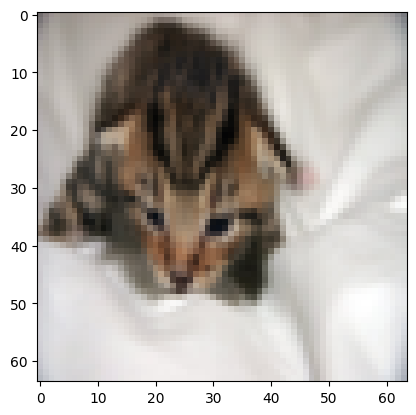

In [86]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

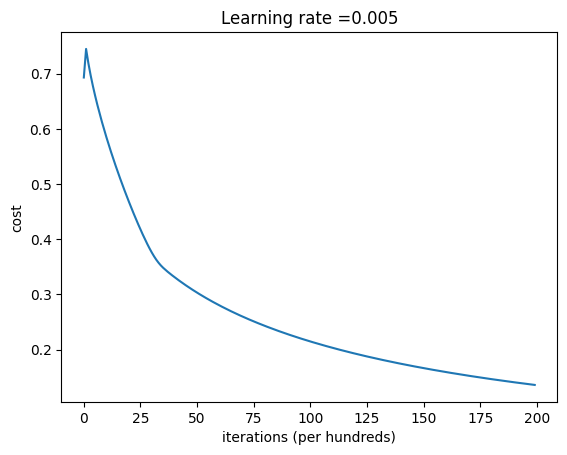

In [87]:
# Plot learning curve (with costs)
costs = np.squeeze([epoch[-1] for epoch in logistic_regression_model['costs']])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called **overfitting**. 

<a name='6'></a>
## 6 - Further analysis

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

[INFO]: Weights initialization done.
[INFO]: Propagation function: Propagate()


Training a model with learning rate: 0.01


[INFO]: Weights optimization done.
[INFO]: Predictions done.
[INFO]: Weights initialization done.
[INFO]: Propagation function: Propagate()



-------------------------------------------------------

Training a model with learning rate: 0.001


[INFO]: Weights optimization done.
[INFO]: Predictions done.
[INFO]: Weights initialization done.
[INFO]: Propagation function: Propagate()



-------------------------------------------------------

Training a model with learning rate: 0.0001


[INFO]: Weights optimization done.
[INFO]: Predictions done.



-------------------------------------------------------



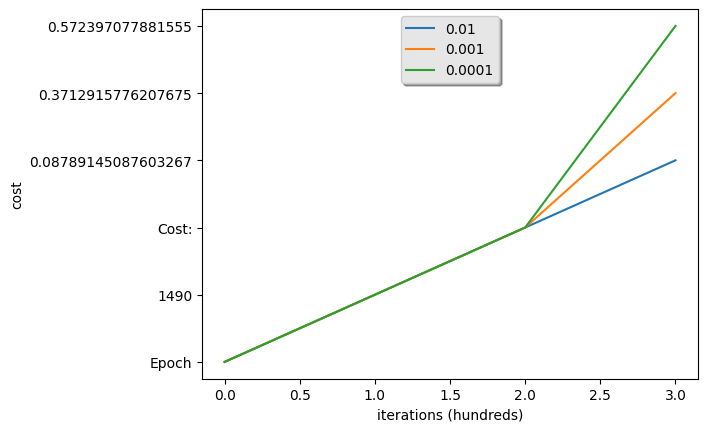

In [88]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"][-1]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


<a name='7'></a>
## 7 - Test with your own image

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:

1. Add your image to this Jupyter Notebook's directory, in the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat).

y = 0, your algorithm predicts a "non-cat" picture.


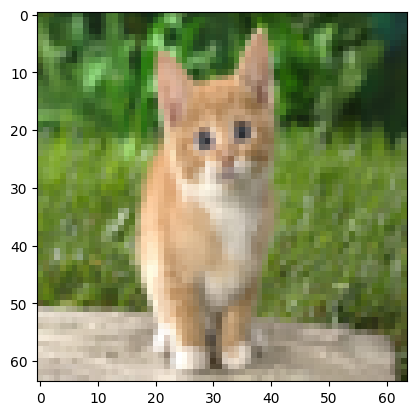

In [89]:
# change this to the name of your image file
my_image = "Cats-image-cats-36712791-1222-917.jpg"   

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

   
**Important:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

**Recommended reading**:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c